In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
PG = pd.read_csv("PG_1995-03_23_2017.csv", index_col = "Date", parse_dates=["Date"])
PG.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-01-03,15.46875,15.62500,15.43750,62.375,15.59375,3318400
1995-01-04,15.53125,15.65625,15.31250,61.875,15.46875,2218800
1995-01-05,15.37500,15.43750,15.21875,61.000,15.25000,2319600


create two separate Simple Moving Averages (SMA) of a time series with differing lookback periods, let’s say, 40 days and 100 days. If the short moving average exceeds the long moving average then you go long, if the long moving average exceeds the short moving average then you exit.

go long: you think that the stock price will go up and will sell at a higher price in the future (= buy signal); 

go short: you sell your stock, expecting that you can buy it back at a lower price and realize a profit (= sell signal).

In [19]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=PG.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = PG['Adj Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = PG['Adj Close'].rolling(window=long_window, min_periods=1, center=False).mean()

In [27]:
# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

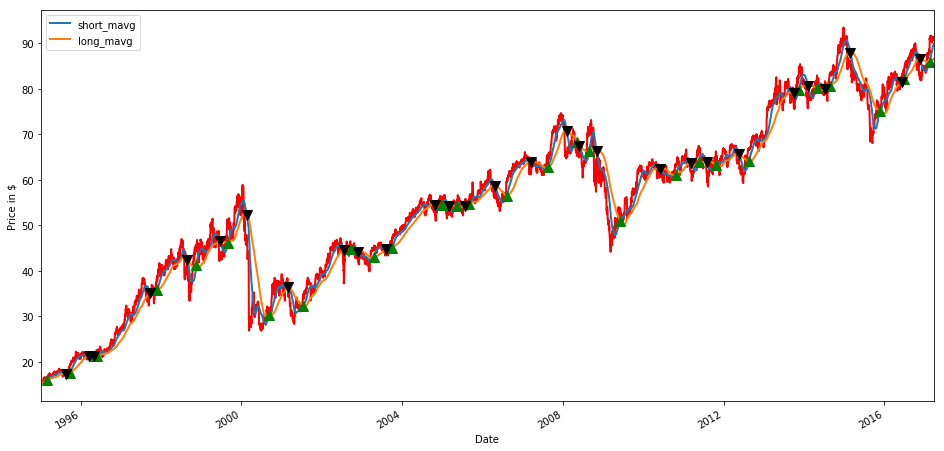

In [31]:
# Initialize the plot figure
fig = plt.figure(figsize=(16,8))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
PG['Adj Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='g')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()